## Part 1. Data Processing and Feature Extraction

In [1]:
from IPython.display import clear_output

### A.1 Data Loading: Collect each directory into Single CSV for weather, lightning datasets 

In [2]:
import os
import shutil
import pandas as pd

FIRE_RECORD = "fp-historical-wildfire-data-2006-2024.csv"
WEATHER_STATION_DIRECTORY = "/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/keep/"
LIGHTNING_DIRECTORY = "/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/lightning_data/"
CITY_POPULATION_CENTER = "/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/population/canadian_cities_with_coords.csv"
GENERATED_NO_FIRE_POINTS = "/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/openweather/veg_fire_no_fire_large.csv"
### 1. Aggregate CSV

from concurrent.futures import ThreadPoolExecutor, as_completed

def load_csvs_into_single_file_multithread(
    source_directory, 
    output_file="all_combined.csv", 
    skip_lines=0, 
    thread_count=4
):
    # list all .csv paths
    csv_files = []
    for root, _, files in os.walk(source_directory):
        for file in files:
            if file.lower().endswith(".csv"):
                csv_files.append(os.path.join(root, file))
    
    total_files = len(csv_files)
    if total_files == 0:
        print("No CSV files found. No output created.")
        return None
    
    # Worker: function read a single CSV
    def read_csv_file(file_path, skip):
        """
        Reads a CSV file with optional skiprows, returning the DataFrame.
        Raises any exception to be handled by caller.
        """
        return pd.read_csv(file_path, encoding='utf-8', low_memory=False, skiprows=skip)
    
    # ThreadPoolExecutor to read files in parallel
    dfs = []
    success_count = 0
    
    print(f"Found {total_files} CSV files. Using {thread_count} thread(s) for parallel loading...\n")
    with ThreadPoolExecutor(max_workers=thread_count) as executor:
        # Submit each file to the pool
        future_to_path = {
            executor.submit(read_csv_file, fpath, skip_lines): fpath
            for fpath in csv_files
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_path):
            file_path = future_to_path[future]
            try:
                df = future.result()  # If an exception occurred, it raises here
                dfs.append(df)
                success_count += 1
                print(f"[Loaded] {file_path} ({success_count}/{total_files})")
            except Exception as e:
                print(f"[Failed] {file_path} — Error: {e}")
    
    # 3. If we have at least one loaded DataFrame, combine them
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df.to_csv(output_file, index=False)
        
        print(f"\nSuccessfully loaded [{success_count}/{total_files}] CSV files.")
        print(f"Combined DataFrame has {combined_df.shape[0]} rows and {combined_df.shape[1]} columns.")
        print(f"Saved merged output to '{output_file}'.")
        return combined_df
    else:
        print("\nNo CSV files loaded successfully. No output created.")
        return None


# Aggregate all data into common csv, only run first time

# lightning_combined = load_csvs_into_single_file_multithread(
#     source_directory=LIGHTNING_DIRECTORY,
#     output_file="all_combined_lightning.csv",
#     skip_lines=2,
#     thread_count=40
# )
# weather_station_combined = load_csvs_into_single_file_multithread(
#     source_directory=LIGHTNING_DIRECTORY,
#     output_file="all_combined_weatherstation.csv",
#     skip_lines=2,
#     thread_count=40
# )




### Data Realization

Data Source 1: Fire Dataset, ground truth of all exsiting fires of Alberta province, are recorded in high precision Latitude and Longtitude and span the map.
- Latitude and longitute labelling.
- Thousands of fires per year.
- Spanning from 1800 - 2025
- Each represent a ground truth point that the training must predict.

Data Source 2: Government Weather Station Dataset, archive of Canadian Weather station, that collect accurate tempreature and rainfall data instead of weather prediction.
- Latitude and longitute labelling. 
- 600 weather stations
- Spanning from 1800 - 2025
- Very few have complete daily data. High Null Rate: 40%

Data Source 3: Daily Lightning Frequency Dataset, arhive of global lightning data with latatude and longtitude labelling.
- Latitude and longitute labelling.
- Millions of lightnings per year.
- Wide Range of Lightning Span, covering almost every location of the country. Data needs to be aggregated statistically or clustered. 

Problems Facing:
- Partially include Latitude and Longtitude of Fire Dataset
- Sptial and Temporal Searching required to assign common ID to weather, lightning, population, and firecase dataset


In [3]:
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
# Load Data Sources
weather_df = pd.read_csv("all_combined_weatherstation.csv", encoding='utf-8', low_memory=False)
lightning_df = pd.read_csv("/mnt/d/446Project/WeatherTransformer/data_processing/combined_alberta_lightning.csv", encoding='utf-8', low_memory=False)
wildfire_df = pd.read_csv("fp-historical-wildfire-data-2006-2024.csv", encoding='utf-8', low_memory=False)
cities_df = pd.read_csv("/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/population/canadian_cities_with_coords.csv")

# Verify Data Source 1: Wildfire Dataset
print("Wildfire Dataset Overview")
print("- Total Fires:", len(wildfire_df))
print("- Latitude Nulls:", wildfire_df['LATITUDE'].isnull().sum())
print("- Longitude Nulls:", wildfire_df['LONGITUDE'].isnull().sum())
print("- Year Range:", wildfire_df['YEAR'].min(), "-", wildfire_df['YEAR'].max())

# Verify Data Source 2: Weather Station Dataset
print("\nWeather Station Dataset Overview")
print("- Total Stations:", weather_df['Station Name'].nunique())
print("- Latitude Nulls:", weather_df['Latitude (y)'].isnull().sum())
print("- Longitude Nulls:", weather_df['Longitude (x)'].isnull().sum())
print("- Date Range:", weather_df['Year'].min(), "-", weather_df['Year'].max())
print("- Data Completeness:", weather_df.isnull().mean().mean()*100, "% null values")

# Verify Data Source 3: Lightning Frequency Dataset
print("\nLightning Dataset Overview")
print("- Total Lightning Strikes:", len(lightning_df[lightning_df["TOTAL_COUNT"] > 0]))
print("- Latitude Nulls:", lightning_df['CENTERLON'].isnull().sum())
print("- Longitude Nulls:", lightning_df['CENTERLAT'].isnull().sum())
print("- Date Range:", lightning_df['ZDAY'][:-4].min(), "-", lightning_df['ZDAY'][:-4].max())

# Problems Facing
print("\nData Integration Issues")
# Checking partial inclusion of latitude and longitude in wildfire dataset
partial_lat_long = wildfire_df[['LATITUDE', 'LONGITUDE']].isnull().any(axis=1).sum()
print("- Fires with partial/missing coordinates:", partial_lat_long)

# Spatial-temporal searching notice
print("- Spatial and Temporal Searching needed to integrate datasets.")

# GeoDF for lightning points
gdf_lightning = gpd.GeoDataFrame(
    lightning_df,
    geometry=gpd.points_from_xy(lightning_df["CENTERLON"], lightning_df["CENTERLAT"]),
    crs="EPSG:4326"
)

urban_coords = cities_df[['latitude', 'longitude']].to_numpy()
urban_tree = cKDTree(urban_coords)

gdf_urban = gpd.GeoDataFrame(
    cities_df,
    geometry=gpd.points_from_xy(cities_df["longitude"], cities_df["latitude"]),
    crs="EPSG:4326"
)
def plot_raw_df():
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 3 maps + 1 composite
    axes = axes.flatten()


Wildfire Dataset Overview
- Total Fires: 26551
- Latitude Nulls: 0
- Longitude Nulls: 0
- Year Range: 2006 - 2024

Weather Station Dataset Overview
- Total Stations: 617
- Latitude Nulls: 0
- Longitude Nulls: 0
- Date Range: 2007 - 2024
- Data Completeness: 50.40384657391092 % null values

Lightning Dataset Overview
- Total Lightning Strikes: 33384
- Latitude Nulls: 0
- Longitude Nulls: 0
- Date Range: 20000510 - 20240918

Data Integration Issues
- Fires with partial/missing coordinates: 0
- Spatial and Temporal Searching needed to integrate datasets.


/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:956: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/miniconda3/lib/python3.12/site-packages/geopandas/plotting.py:956: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw_idle()
/home/y344shi/m

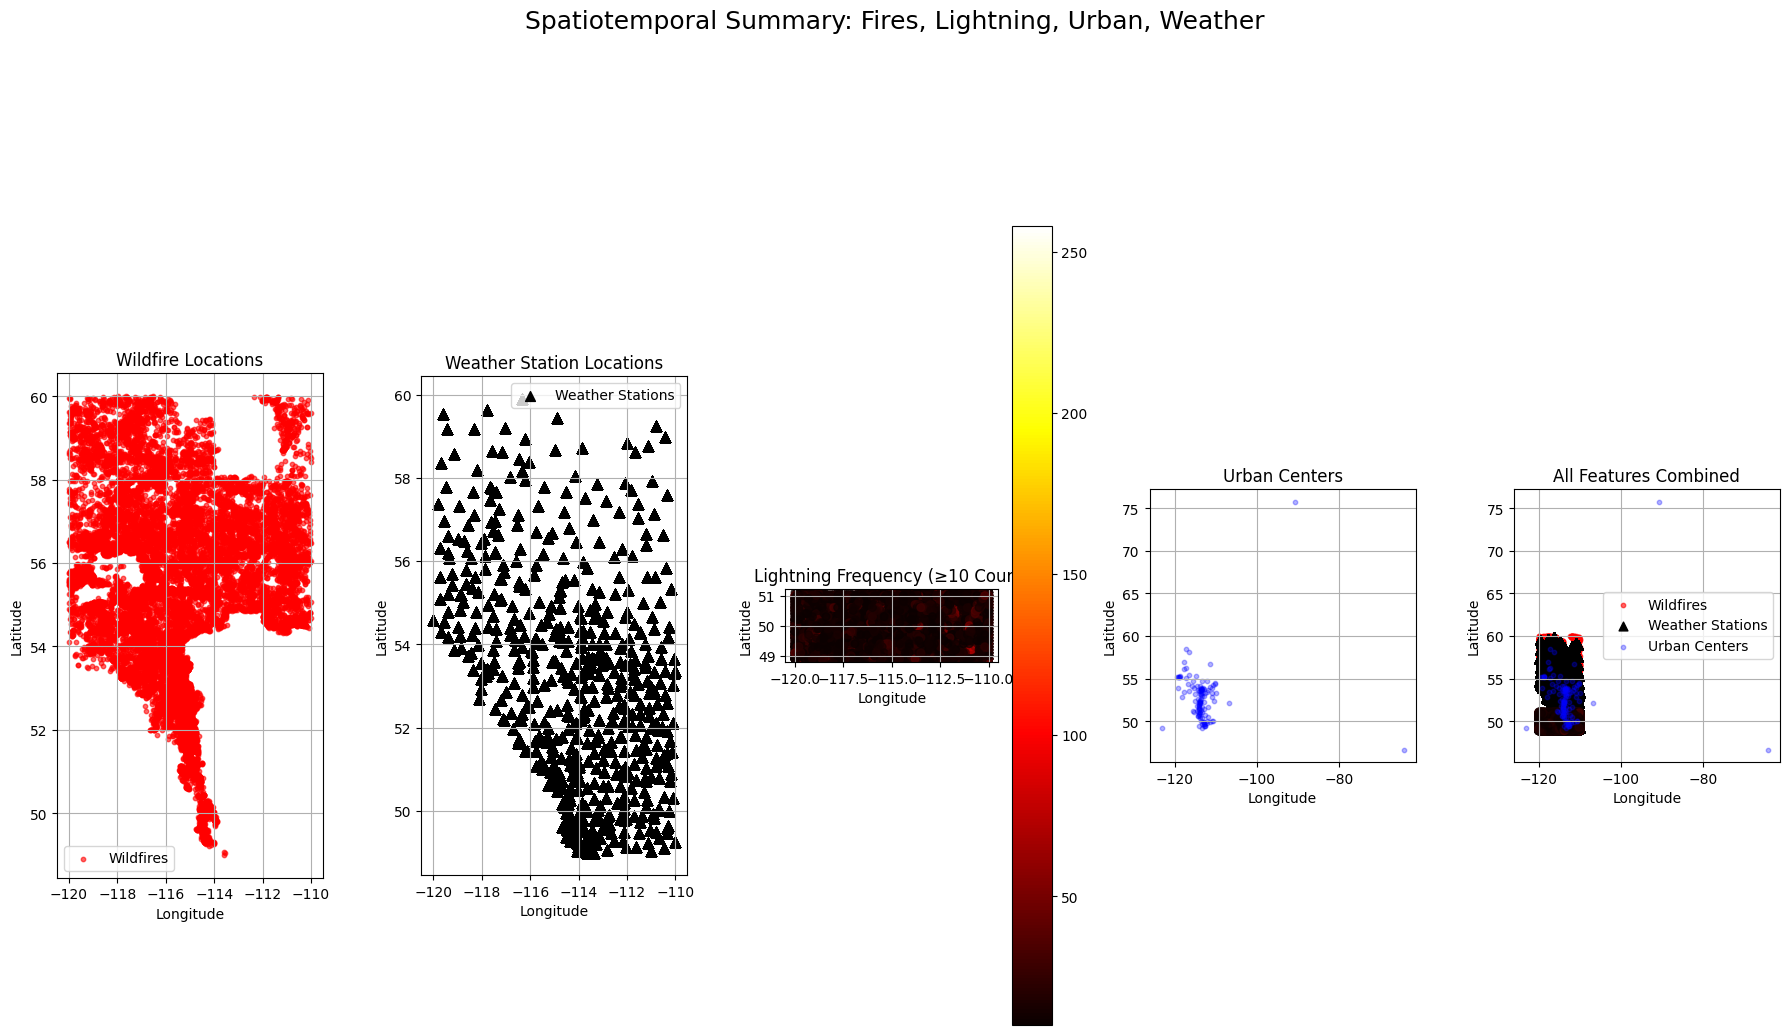

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_geospatial_summary(wildfire_df, weather_df, lightning_df, cities_df):
    """
    Plots 4 subplots:
        1. Wildfire locations
        2. Weather station locations
        3. Lightning strike frequency (≥10)
        4. Composite map with all layers

    Args:
        wildfire_df (pd.DataFrame): Wildfire records with LATITUDE and LONGITUDE
        weather_df (pd.DataFrame): Weather station data with Latitude (y) and Longitude (x)
        lightning_df (pd.DataFrame): Lightning strike data with TOTAL_COUNT
        cities_df (pd.DataFrame): City data with lat/lon and urban info
    """
    ### --- GeoDataFrames ---

    gdf_fire = gpd.GeoDataFrame(
        wildfire_df,
        geometry=gpd.points_from_xy(wildfire_df["LONGITUDE"], wildfire_df["LATITUDE"]),
        crs="EPSG:4326"
    )

    gdf_weather = gpd.GeoDataFrame(
        weather_df,
        geometry=gpd.points_from_xy(weather_df["Longitude (x)"], weather_df["Latitude (y)"]),
        crs="EPSG:4326"
    )

    # Filter Alberta & significant lightning
    alberta_bounds = {
        "lat_min": 48.9, "lat_max": 60.0,
        "lon_min": -120.0, "lon_max": -110.0
    }
    df_lightning_filtered = lightning_df[
        (lightning_df["CENTERLAT"] >= alberta_bounds["lat_min"]) &
        (lightning_df["CENTERLAT"] <= alberta_bounds["lat_max"]) &
        (lightning_df["CENTERLON"] >= alberta_bounds["lon_min"]) &
        (lightning_df["CENTERLON"] <= alberta_bounds["lon_max"]) &
        (lightning_df["TOTAL_COUNT"] >= 10)
    ]
    gdf_lightning = gpd.GeoDataFrame(
        df_lightning_filtered,
        geometry=gpd.points_from_xy(df_lightning_filtered["CENTERLON"], df_lightning_filtered["CENTERLAT"]),
        crs="EPSG:4326"
    )

    gdf_urban = gpd.GeoDataFrame(
        cities_df,
        geometry=gpd.points_from_xy(cities_df["longitude"], cities_df["latitude"]),
        crs="EPSG:4326"
    )

    fig, axes = plt.subplots(1, 5, figsize=(18, 12))
    axes = axes.flatten()

    # Subplot 0: Wildfires
    ax0 = axes[0]
    gdf_fire.plot(ax=ax0, color='red', alpha=0.6, markersize=10, label='Wildfires')
    ax0.set_title("Wildfire Locations")
    ax0.set_xlabel("Longitude")
    ax0.set_ylabel("Latitude")
    ax0.legend()
    ax0.grid(True)

    # Subplot 1: Weather Stations
    ax1 = axes[1]
    gdf_weather.plot(ax=ax1, color='black', marker='^', markersize=50, label='Weather Stations')
    ax1.set_title("Weather Station Locations")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.legend()
    ax1.grid(True)

    # Subplot 2: Lightning
    ax2 = axes[2]
    gdf_lightning.plot(ax=ax2, column="TOTAL_COUNT", cmap="hot", markersize=30, alpha=0.7, legend=True)
    ax2.set_title("Lightning Frequency (≥10 Count)")
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.grid(True)

    
    # Subplot 3: Urban center
    ax3 = axes[3]
    gdf_urban.plot(ax=ax3, color='blue', markersize=10, alpha=0.3, label='Urban Centers')
    ax3.set_title("Urban Centers")
    ax3.set_xlabel("Longitude")
    ax3.set_ylabel("Latitude")
    ax3.grid(True)

    # Subplot 3: Composite
    ax4 = axes[4]
    gdf_fire.plot(ax=ax4, color='red', markersize=10, alpha=0.6, label='Wildfires')
    gdf_weather.plot(ax=ax4, color='black', marker='^', markersize=40, label='Weather Stations')
    gdf_lightning.plot(ax=ax4, column="TOTAL_COUNT", cmap="hot", markersize=30, alpha=0.5, legend=False)
    gdf_urban.plot(ax=ax4, color='blue', markersize=10, alpha=0.3, label='Urban Centers')

    ax4.set_title("All Features Combined")
    ax4.set_xlabel("Longitude")
    ax4.set_ylabel("Latitude")
    ax4.legend()
    ax4.grid(True)

    ### --- Final Display ---
    plt.suptitle("Spatiotemporal Summary: Fires, Lightning, Urban, Weather", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

plot_geospatial_summary(
    wildfire_df=wildfire_df,
    weather_df=weather_df,
    lightning_df=lightning_df,
    cities_df=cities_df
)


### Initial Clustering to visualize data distribution

- **Geospatial Processing:**
  - Geopandas used to create geospatial dataframes (`GeoDataFrame`) from both wildfire and weather station datasets.
  - Confirmed spatial accuracy by ensuring weather stations fall strictly within the defined Alberta geographical bounds.

- **Wildfire-to-Weather Station Clustering:**
  - Applied the `pairwise_distances_argmin_min` function to assign each wildfire incident to its closest weather station, effectively clustering wildfires spatially based on proximity.

- **Visualization:**
  - A clear, color-coded scatter plot using Matplotlib, distinguishing wildfires by their nearest weather station.
  - Weather stations visually represented with distinct markers, enabling easy interpretation of wildfire clusters relative to weather station locations.

- **Station Identification:**
  - Created mapping dictionaries linking station IDs to their corresponding names, facilitating easier interpretation and further analysis.

Weather stations after Alberta + bounds filter: 651
rainbow length 311


/tmp/ipykernel_838200/4019410581.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_ncar', n)


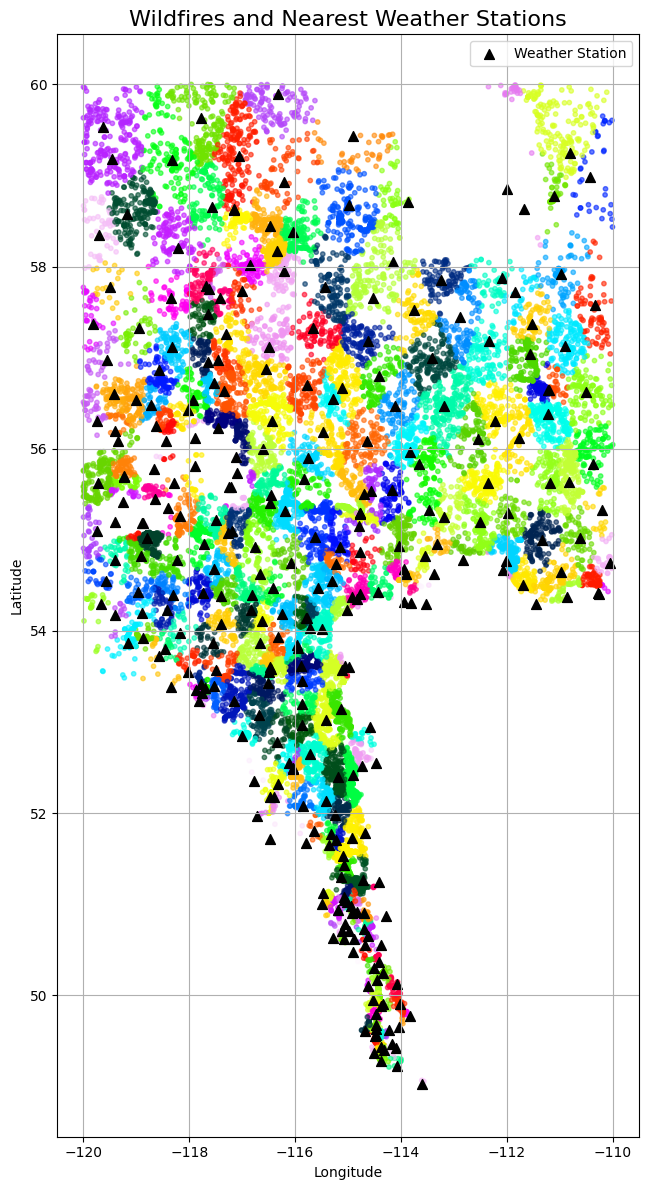

{'1814': 'AURORA LO', '1815': 'BASELINE LO', '1822': 'BLACKSTONE LO', '1823': 'BRAZEAU LO', '1848': 'CLEARWATER', '27260': 'ELK RIVER AFS', '8712': 'ROCKY MTN HOUSE (AUT)', '1967': 'ST LINA', '30643': 'VIOLET GROVE CS', '2017': 'WINFIELD', '1799': 'HORBURG', '55338': 'PIBROCH AGCM', '8723': 'COALCAMP CREEK', '43561': 'LEEDALE AGDM', '2108': 'LOBSTICK AUBUCHON', '10105': 'SUNDRE A', '8753': 'BEAUVAIS PARK', '42443': 'COCHRANE BIGHILL CREEK', '2231': 'CONNELLY CREEK', '31089': 'COWLEY TANNER', '2239': 'FIVE MILE CREEK', '48468': 'PRIDDIS OBSERVATORY', '43363': 'WILDCAT HILLS', '2363': 'BALDY LO', '27295': 'BARRIER LAKE', '2366': 'BEAVER MINES', '2365': 'BIGHORN DAM', '2368': 'BLUEHILL LO', '10222': 'BOW VALLEY', '8924': 'BURNS CREEK', '2375': 'CARBONDALE LO', '2377': 'CASTLE', '2379': 'CLINE LO', '8914': 'COMPRESSION RIDGE', '8724': 'COX HILL', '10690': 'CROWSNEST CREEK', '10890': 'CROWSNEST', '2386': 'ELBOW RS', '8825': 'FALLEN TIMBER', '8824': 'FORGET ME NOT MOUNTAIN', '27716': "GOAT'S

In [5]:
# Re-import required libraries after code execution environment reset
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

alberta_bounds = {
    "lat_min": 48.9,
    "lat_max": 60.0,
    "lon_min": -120.0,
    "lon_max": -110.0
}


# Define the class again
class WildfireWeatherAnalysis:
    def __init__(self, wildfire_file, weather_file):
        self.wildfire_file = wildfire_file
        self.weather_file = weather_file
        self.wildfire_df = None
        self.clustered_gdf = None
        self.weather_gdf = None

    def load_data(self):
        # Load wildfire data
        if self.wildfire_file.endswith('.xlsx'):
            excel_file = pd.ExcelFile(self.wildfire_file)
            self.wildfire_df = pd.read_excel(excel_file, sheet_name="2006-2024")
        elif self.wildfire_file.endswith('.csv'):
            self.wildfire_df = pd.read_csv(self.wildfire_file)
        else:
            raise ValueError("Unsupported wildfire file format")

        # Load weather station data
        weather_df = pd.read_csv(self.weather_file, skiprows=0, quotechar='"')
        weather_df = weather_df[weather_df["Province"].str.upper() == "ALBERTA"]

        # Ensure stations are within Alberta
        weather_df["Station ID"] = weather_df["Station ID"].astype(str)
        kept = ['1977', '48550', '8884', '2823', '48949', '2586', '46827', '10225', '2511', '2613', '51497', '27031', '2663', '41785', '51377', '2605', '2553', '51500', '50920', '27652', '2767', '30726', '2693', '10864', '1805', '2770', '2797', '2471', '2502', '10105', '2479', '2788', '2704', '27212', '46447', '27037', '32455', '2402', '2173', '42727', '43151', '53998', '8893', '2416', '42443', '8838', '2323', '26888', '46910', '9010', '32333', '2745', '2750', '2732', '1823', '27713', '1984', '2395', '2685', '2301', '52258', '2593', '50757', '2489', '2102', '27219', '55538', '27825', '45887', '2656', '43581', '10689', '8924', '6853', '53078', '53100', '2570', '8824', '27455', '47090', '2407', '2578', '2562', '50149', '47748', '8819', '47073', '50940', '2604', '1898', '47147', '27261', '31027', '2368', '42726', '46127', '2339', '27655', '2564', '2460', '46847', '32394', '2677', '2134', '2517', '32255', '51498', '46132', '51578', '1920', '1953', '2722', '1825', '2626', '27715', '10907', '51858', '2690', '51422', '1896', '53098', '27041', '2001', '32149', '50622', '2092', '8804', '2764', '2700', '46811', '2431', '2169', '27658', '8857', '2454', '53999', '2409', '46787', '2657', '50937', '27828', '1884', '2556', '44266', '43147', '51838', '32256', '1839', '2274', '55338', '27213', '46851', '55018', '31608', '2423', '50129', '2086', '2814', '2596', '51444', '42728', '54358', '45748', '45927', '8859', '47107', '2377', '32253', '31411', '31447', '50939', '32454', '2072', '2694', '46849', '31409', '46729', '2648', '1814', '2432', '2519', '8918', '50922', '2224', '2103', '47068', '2795', '2635', '45767', '2050', '2528', '45907', '1881', '8712', '30643', '41784', '2405', '2273', '8830', '46467', '2621', '9609', '10708', '2231', '2765', '2829', '50918', '50921', '31427', '32458', '2538', '31468', '6860', '2731', '2737', '43783', '47089', '2542', '2832', '27650', '42731', '2790', '2590', '2144', '50623', '1799', '2624', '30495', '46468', '2386', '2594', '1967', '8837', '2778', '1835', '47076', '46128', '2440', '53738', '32456', '47087', '2601', '2113', '2746', '1812', '2016', '2597', '1857', '47070', '2457', '46914', '32274', '46130', '46129', '8872', '2025', '2174', '50128', '30641', '2809', '2482', '50028', '30543', '2347', '2500', '54478', '47108', '1935', '10104', '47071', '1915', '8900', '29926', '46807', '2813', '2680', '47128', '2819', '49949', '2400', '30055', '53099', '51499', '2666', '49968', '10906', '42724', '2108', '2655', '2461', '49268', '2567', '42703', '27653', '2392', '2668', '46852', '49490', '31207', '46913', '27492', '2112', '2425', '31089', '2263', '2467', '8917', '2503', '46810', '2523', '2504', '55419', '53718', '2312', '2632', '2573', '46734', '47747', '2654', '31408', '41757', '2276', '49048', '46470', '2017', '51840', '46912', '2689', '2757', '50311', '8753', '2150', '2515', '2255', '2485', '46927', '53918', '2462', '2141', '2258', '2219', '50917', '43150', '2803', '52982', '9015', '46867', '2429', '10222', '2658', '1801', '47077', '2068', '2459', '45727', '2411', '27656', '2684', '9611', '32231', '2492', '46469', '10725', '46327', '2227', '27216', '27295', '2712', '1822', '44746', '10665', '50938', '32459', '32232', '46848', '45947', '10915', '26971', '2438', '8895', '46131', '42729', '32257', '43148', '47047', '2634', '2721', '2821', '55418', '2171', '8723', '43580', '43363', '49369', '30310', '45847', '47767', '2122', '51898', '2521', '2510', '2675', '2783', '2782', '2539', '31410', '51501', '2366', '43164', '46732', '46808', '2755', '48948', '30669', '2762', '2239', '46907', '31412', '45749', '2375', '32313', '53198', '2628', '2718', '2572', '2794', '27200', '2641', '27214', '2735', '10930', '45647', '30907', '27793', '1904', '49948', '27260', '47110', '1990', '2205', '42730', '2481', '46850', '45867', '2701', '2513', '2804', '2673', '46767', '2667', '43561', '41783', '2452', '2811', '2404', '50777', '10223', '27030', '27029', '2363', '47075', '48975', '2761', '42283', '2736', '1868', '27262', '2800', '27217', '2719', '2078', '27716', '2592', '2120', '45948', '27845', '29633', '2379', '10700', '2332', '2140', '10928', '10793', '8791', '32395', '8856', '43149', '42164', '2247', '49368', '30347', '46887', '9410', '47072', '46730', '2493', '2218', '1865', '31588', '2486', '2614', '46731', '2279', '2537', '1958', '2674', '45747', '42163', '31469', '2295', '8916', '2410', '2393', '52358', '32273', '52200', '46909', '1828', '2793', '31288', '46471', '46809', '1848', '26870', '27040', '1815', '2315', '9604', '47067', '51841', '2781', '2639', '10183', '1859', '51440', '10693', '47074', '54718', '32461', '27038', '1873', '49928', '54000', '42725', '27036', '50919', '2180', '27018', '46928', '48468', '8825', '47069', '10889', '47727', '52459', '8915', '1886', '2084', '46908', '55478', '10932', '10691', '27211', '47787', '29573', '49050', '2265', '27378', '32460', '8920', '2508', '31528', '31414', '10978', '1872', '30433', '2580', '2123', '2830', '46911', '6865', '1974', '1870', '27199', '50923', '2650', '2622', '8724', '2577', '2145', '49049', '2726', '2490', '43560', '27657', '2545', '47088', '31413', '51839', '51899', '32453', '2739', '2133', '27218', '53358', '46733', '27263', '1829', '51758', '9610', '6854', '2501', '31407', '32230', '52458', '32457', '8919', '2779', '10690', '2396', '1843', '9608', '42723', '26850', '47109', '2561', '47127', '2818', '6863', '2417', '1840', '46812', '2649', '31198', '2806', '52478', '50430', '2543', '10890', '2544', '8855', '27654', '55118', '9436', '2740', '55098', '27331', '51502', '32254', '46853', '8851', '2365', '2522', '32433', '8914']
        weather_df = weather_df[weather_df['Station ID'].astype(str).isin(kept)]
        weather_df = weather_df.dropna(subset=["Latitude (Decimal Degrees)", "Longitude (Decimal Degrees)"])
        weather_df = weather_df[
            (weather_df["Province"].str.upper() == "ALBERTA") &
            (weather_df["Latitude (Decimal Degrees)"].between(alberta_bounds["lat_min"], alberta_bounds["lat_max"])) &
            (weather_df["Longitude (Decimal Degrees)"].between(alberta_bounds["lon_min"], alberta_bounds["lon_max"]))
        ]
        print("Weather stations after Alberta + bounds filter:", len(weather_df))


        self.weather_gdf = gpd.GeoDataFrame(
            weather_df,
            geometry=gpd.points_from_xy(weather_df["Longitude (Decimal Degrees)"], weather_df["Latitude (Decimal Degrees)"]),
            crs="EPSG:4326"
        )

        self.cluster_wildfires_analyze()

        self.weather_gdf = self.weather_gdf[self.weather_gdf["Station ID"].isin(self.wildfire_df["Station ID"].to_list())]


    def plot_clusters_with_weather(self):
        fig, ax = plt.subplots(figsize=(15, 12))

        # Use same color mapping logic
        station_ids = self.clustered_gdf['Station ID'].astype(str).unique()
        n = len(station_ids)
        print("rainbow length", n)
        cmap = cm.get_cmap('gist_ncar', n)
        color_map = {station: mcolors.rgb2hex(cmap(i)) for i, station in enumerate(station_ids)}
        self.clustered_gdf['color'] = self.clustered_gdf['Station ID'].astype(str).map(color_map)

        self.clustered_gdf.plot(ax=ax, color=self.clustered_gdf['color'], markersize=10, alpha=0.6)
        self.weather_gdf.plot(ax=ax, color='black', marker='^', label='Weather Station', markersize=50)

        ax.set_title("Wildfires and Nearest Weather Stations", fontsize=16)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        return station_ids


    def cluster_wildfires_analyze(self):
        # Coordinates of weather station and wildfire are extracted
        wildfire_coords = self.wildfire_df[['LATITUDE', 'LONGITUDE']].dropna().copy()
        weather_coords = self.weather_gdf[['Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)']].to_numpy()

        # Find closest station of each station
        station_ids = self.weather_gdf['Station ID'].to_numpy()
        fire_coords = wildfire_coords[['LATITUDE', 'LONGITUDE']].to_numpy()
        closest_indices, _ = pairwise_distances_argmin_min(fire_coords, weather_coords)

        # Map each wildfire to its nearest station ID
        wildfire_coords['Station ID'] = station_ids[closest_indices]
        
        # Merge the cluster assignment back into original df
        self.wildfire_df = self.wildfire_df.merge(wildfire_coords[['LATITUDE', 'LONGITUDE', 'Station ID']], 
                                on=['LATITUDE', 'LONGITUDE'], 
                                how='left')
        
        self.clustered_gdf = gpd.GeoDataFrame(
            wildfire_coords,
            geometry=gpd.points_from_xy(wildfire_coords['LONGITUDE'], wildfire_coords['LATITUDE']),
            crs="EPSG:4326"
        )

        return wildfire_coords

    def lookup_station_names(self, list_of_id):
        # create fire station name to ID lookup table to be used when processing individual weather stations
        df = self.weather_gdf.copy()
        df = df[["Name", "Station ID"]].copy()

        # Filter to only those in the provided list
        matched = df[df['Station ID'].isin(list_of_id)]
        
        # Return as a dictionary {id: name}
        return dict(zip(matched['Station ID'], matched['Name'])), dict(zip(matched['Name'], matched['Station ID'])),



# Instantiate and run the analysis
analysis = WildfireWeatherAnalysis(
    wildfire_file="fp-historical-wildfire-data-2006-2024.csv",
    weather_file="StationInventoryEN.csv"
)
analysis.load_data()

clustered_fire_df = analysis.cluster_wildfires_analyze()
filtered_stationID = analysis.plot_clusters_with_weather()

id2name_lookup, name2id_lookup = analysis.lookup_station_names(filtered_stationID)
print(id2name_lookup, name2id_lookup)
filtered_stationName = []
for id in filtered_stationID:
    filtered_stationName.append(id2name_lookup.get(id))
print(filtered_stationName)


### A.3 NULL TEST
#### Statistical Analysis are performed to evaluate the quality of weather station data on each category.

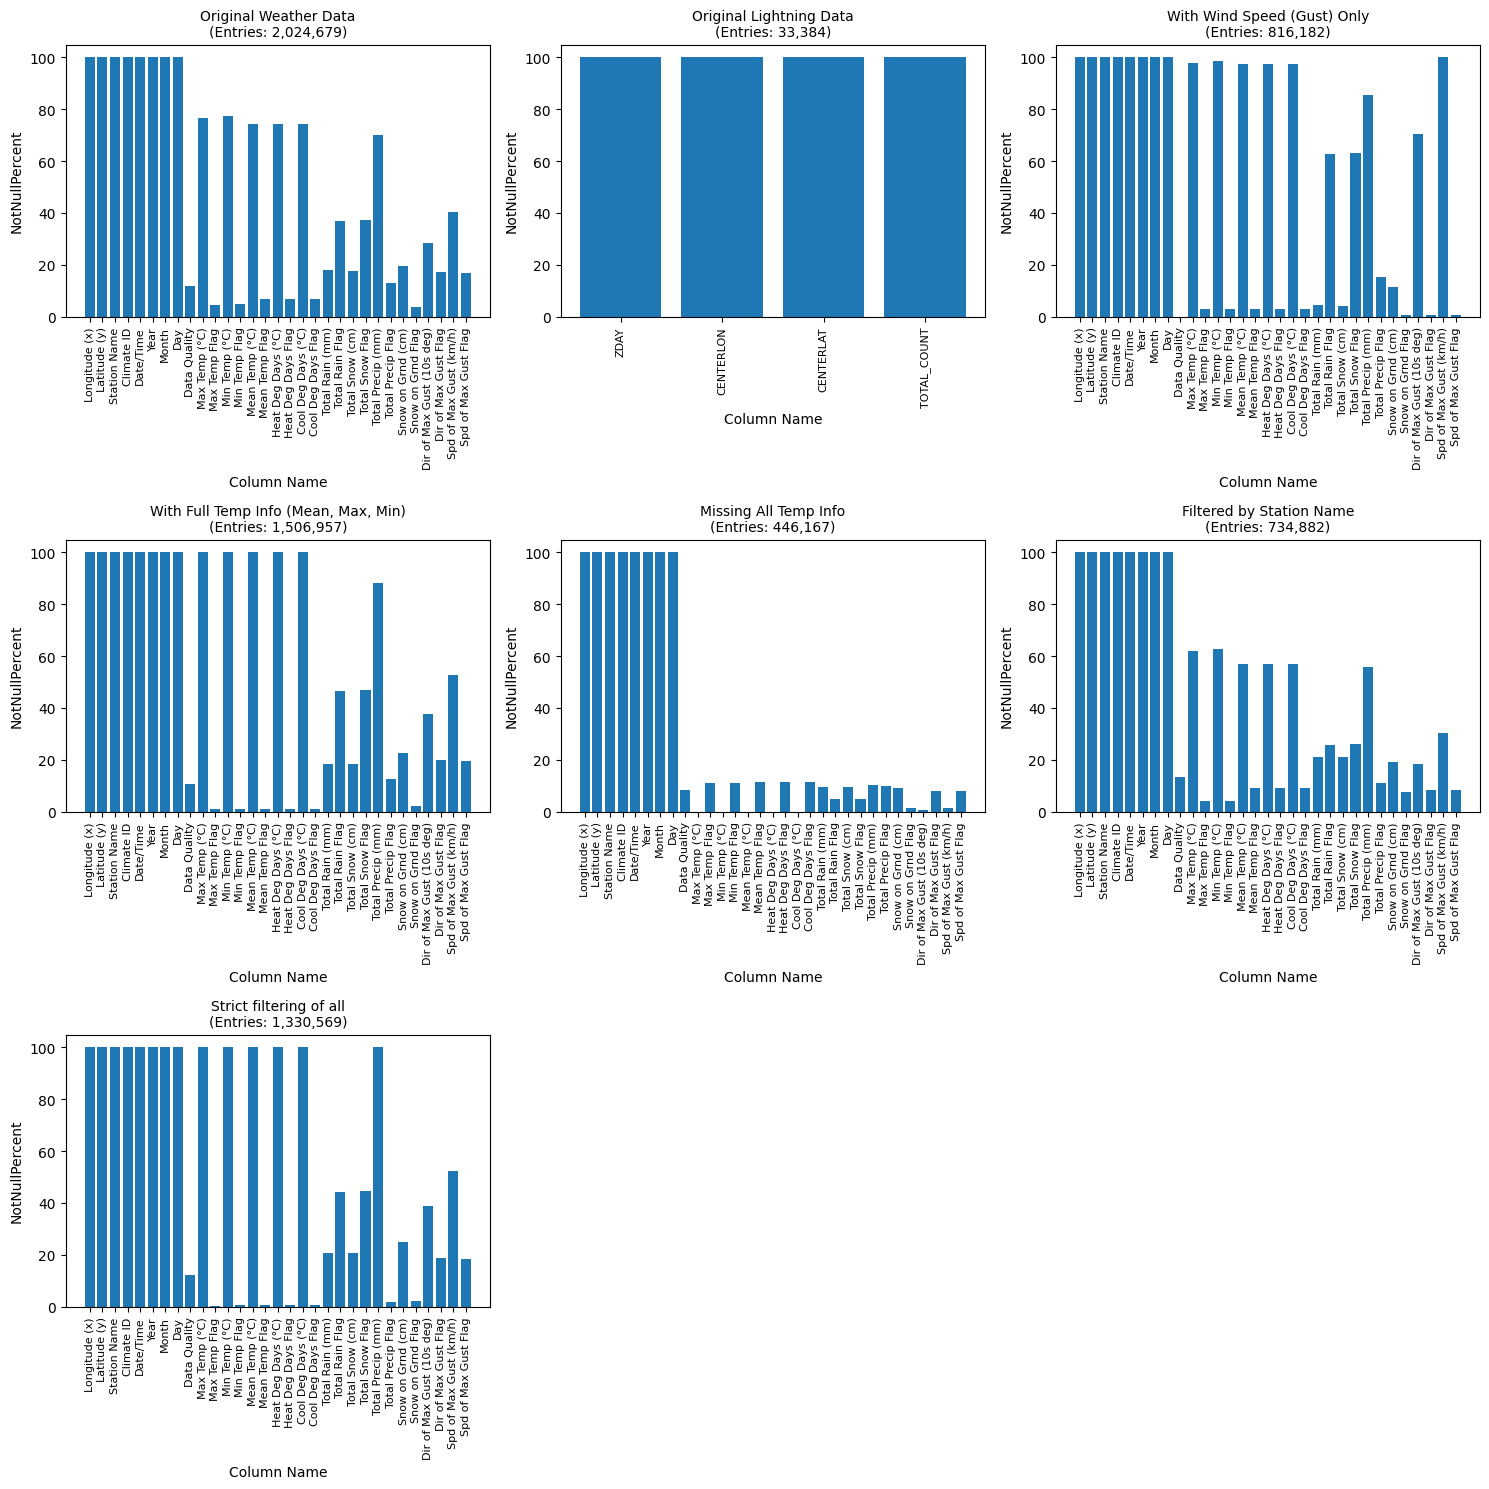

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt

def column_empty_report(df):
    """
    Returns a DataFrame summarizing how many rows in each column are empty 
    (NaN) and the percentage of empties out of total rows.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame to analyze.
    
    Returns
    -------
    pd.DataFrame
        A table with columns:
            'ColumnName'   : The original column name
            'EmptyCount'   : Number of rows that are NaN in this column
            'EmptyPercent' : Percentage of rows that are NaN (0.00 to 100.00)
            'Report'       : String showing both the count and percentage
    """
    total_rows = len(df)
    results = []

    for col in df.columns:
        empty_count = df[col].isna().sum()
        
        # Calculate percentage (avoid divide-by-zero if DF is empty)
        if total_rows > 0:
            empty_percent = (empty_count / total_rows) * 100
        else:
            empty_percent = 0.0
        
        results.append({
            "ColumnName": col,
            "EmptyCount": empty_count,
            "EmptyPercent": round(empty_percent, 2)
        })
        
    return pd.DataFrame(results)



def plot_two_dataframes(df_tuples):
    n = len(df_tuples)
    if n == 0:
        print("No DataFrames to plot.")
        return

    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows), sharey=False)

    # Flatten axes for easy iteration (in case of single row/col)
    if rows == 1:
        axes = [axes] if n == 1 else axes
    else:
        axes = axes.flatten()

    for i, (title, df) in enumerate(df_tuples):
        og_df = df.copy()
        df = column_empty_report(df)
        df["NotNullPercent"] = 100 - df["EmptyPercent"]
        ax = axes[i]

        ax.bar(df["ColumnName"], df["NotNullPercent"])

        # Estimate entry count from percent math
        entry_count = og_df.iloc[:, 0].notna().sum()

        ax.set_title(f"{title}\n(Entries: {entry_count:,})", fontsize=10)
        ax.set_xlabel("Column Name")
        ax.set_ylabel("NotNullPercent")
        ax.tick_params(axis='x', labelrotation=90, labelsize=8)

    # Turn off any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


weather_df_validity = column_empty_report(weather_df)
lightning_df_validity = column_empty_report(lightning_df)
df_with_wind = weather_df[weather_df["Spd of Max Gust (km/h)"].notnull()]
df_without_wind = weather_df[weather_df["Spd of Max Gust (km/h)"].isnull()]
df_without_tmp = weather_df[weather_df["Mean Temp (°C)"].isnull()]
df_without_tmp = df_without_tmp[df_without_tmp["Max Temp (°C)"].isnull()]
df_without_tmp = df_without_tmp[df_without_tmp["Min Temp (°C)"].isnull()]

df_with_tmp = weather_df[weather_df["Mean Temp (°C)"].notnull()]
df_with_tmp = df_with_tmp[df_with_tmp["Max Temp (°C)"].notnull()]
df_with_tmp = df_with_tmp[df_with_tmp["Min Temp (°C)"].notnull()]

df_filtered_tmp = weather_df[weather_df["Station Name"].isin(filtered_stationName)]

required_columns = [
    # "Spd of Max Gust (km/h)",
    "Total Precip (mm)",
    "Mean Temp (°C)",
    "Min Temp (°C)",
    "Max Temp (°C)"
]
weather_df_strict = weather_df.dropna(subset=required_columns)

df_tuples = [
    ("Original Weather Data", weather_df),
    ("Original Lightning Data", lightning_df),
    ("With Wind Speed (Gust) Only", df_with_wind),
    ("With Full Temp Info (Mean, Max, Min)", df_with_tmp),
    ("Missing All Temp Info", df_without_tmp),
    ("Filtered by Station Name", df_filtered_tmp),
    ("Strict filtering of all", weather_df_strict)
]

plot_two_dataframes(df_tuples)
# print(df_without_tmp)

In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def plot_stations(df):
    fig, ax = plt.subplots(figsize=(15, 12))
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["Longitude (x)"], df["Latitude (y)"]),
        crs="EPSG:4326"
    )
    gdf.plot(ax=ax, color='black', marker='^', label='Weather Station', markersize=50)

    ax.set_title("Wildfires and Nearest Weather Stations", fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# plot_stations(weather_df_strict)


## A.2 Wildfire and Weather Station Spatial AnalysisCommon ID Problem: 
There are around 20,000 fires a year, and only 600 weather stations across the Alberta district with accurate recordings., much more fire locations and lightning locations than that the weather station can cover. 

In order to connect exsisting Fire data to weather stations' historical data in Alberta, one must assign a common index system that represent weather condition around the fire location.

1. Clustering Fire Events: To cluster with K-Means clustering where K = Number of DataStation.

2. Closest Neighbour: Identify Regions of Monitoring, associate each Fire Record with a weather station that is closets to it, to reflect the nearby weather data

The goal was to associate historical wildfire incidents in Alberta (2006-2024) with the nearest weather stations and visualize these clusters for further weather analysis.





/tmp/ipykernel_838200/4228589514.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<31' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  veg_df.at[idx, col] = matched_weather.get(col, np.nan)


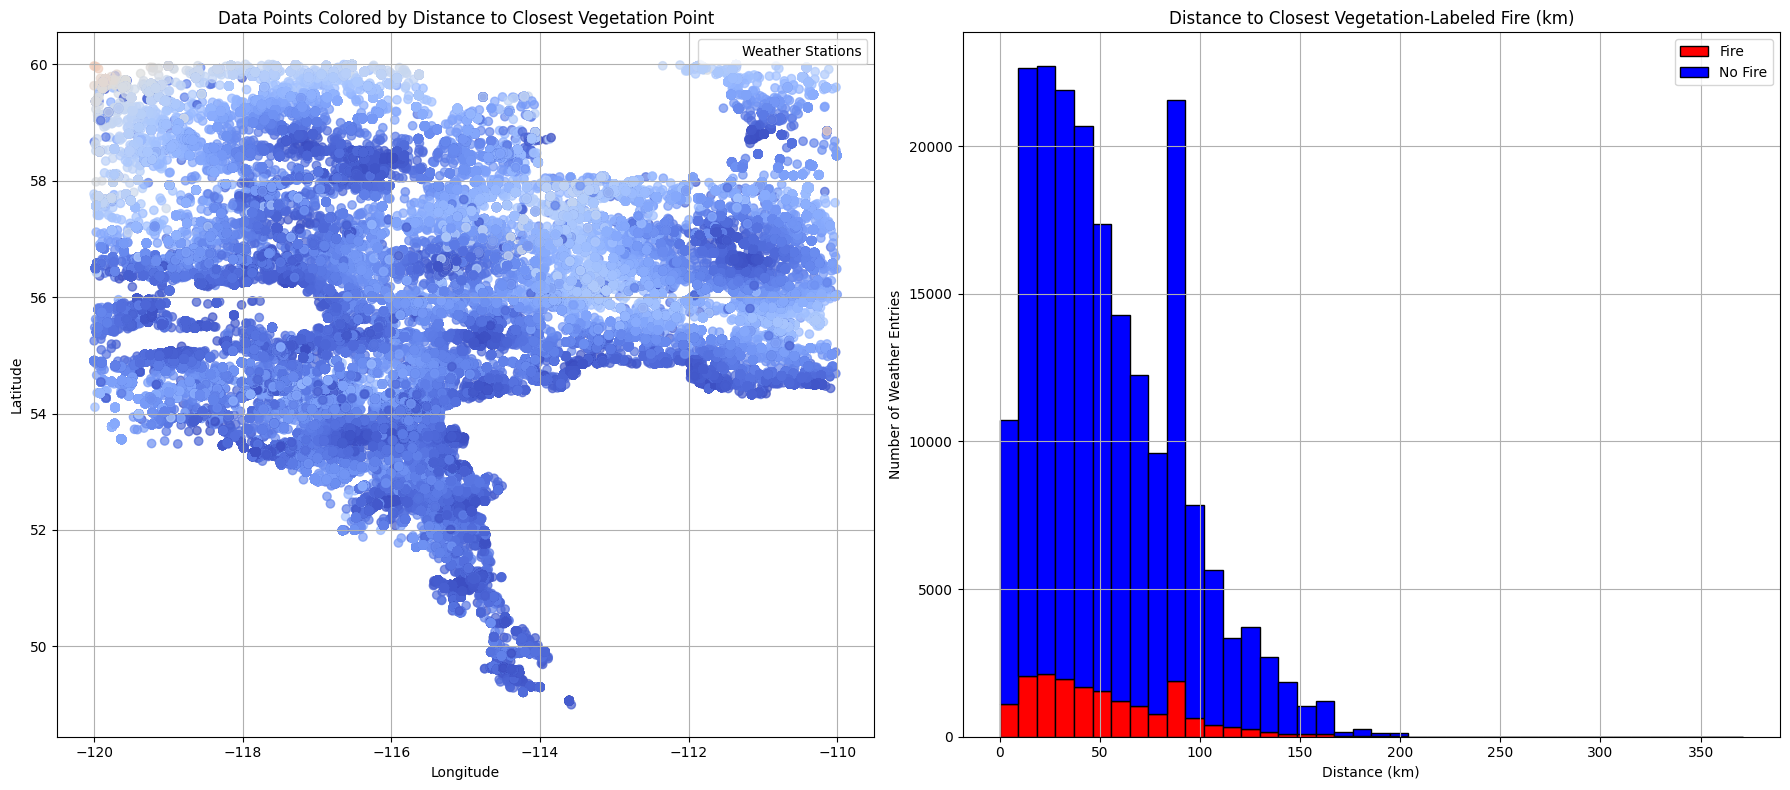

<Figure size 640x480 with 0 Axes>

Within 50km distance [106085/203177]


In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, sin, cos, sqrt, asin
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

def plot_vegetation(veg_weather_df):
    # Plotting weather stations colored by inferred vegetation type
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Scatter plot of vegetation centers (wildfires)
    # axes[0].scatter(weather_df_enriched["Longitude (x)"], wildfire_df["Latitude (y)"], 
    #                 alpha=0.4, label="Vegetation Centers (Wildfires)", color="green")
    axes[0].scatter(veg_weather_df["LONGITUDE"], veg_weather_df["LATITUDE"], 
                    c=veg_weather_df["Distance to Weather Station (km)"], cmap="coolwarm", alpha=0.7, label="Weather Stations")
    axes[0].set_title("Data Points Colored by Distance to Closest Vegetation Point")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].legend()
    axes[0].grid(True)


    # Split into Fire and No Fire
    fire_true = veg_weather_df[veg_weather_df["FIRE"] == True]["Distance to Weather Station (km)"].dropna()
    fire_false = veg_weather_df[veg_weather_df["FIRE"] == False]["Distance to Weather Station (km)"].dropna()

    # Plot histogram with two colors
    axes[1].hist([fire_true, fire_false], bins=40, stacked=True, label=["Fire", "No Fire"], color=["red", "blue"], edgecolor="black")

    axes[1].set_title("Distance to Closest Vegetation-Labeled Fire (km)")
    axes[1].set_xlabel("Distance (km)")
    axes[1].set_ylabel("Number of Weather Entries")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    plt.show()

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Earth radius in km


def match_vegetation_to_weather(veg_df, weather_df):
    veg_df = veg_df.copy()
    weather_df = weather_df.copy()
    veg_df["Date"] = pd.to_datetime(veg_df["START_DATE"]).dt.date
    weather_df["Date"] = pd.to_datetime(weather_df["Date/Time"]).dt.date

    weather_by_date = weather_df.groupby("Date")

    matched_rows = []
    matched_distances = []

    required_columns = [
        "Spd of Max Gust (km/h)",
        "Total Precip (mm)",
        "Mean Temp (°C)",
        "Min Temp (°C)",
        "Max Temp (°C)",
        "Distance to Weather Station (km)"
    ]
    for col in required_columns:
        veg_df[col] = np.nan

    for idx, row in veg_df.iterrows():
        date = row["Date"]
        lat = row["LATITUDE"]
        lon = row["LONGITUDE"]

        if pd.isna(lat) or pd.isna(lon) or date not in weather_by_date.groups:
            matched_rows.append(None)
            matched_distances.append(np.nan)
            continue

        day_weather = weather_by_date.get_group(date)
        lats = day_weather["Latitude (y)"].values
        lons = day_weather["Longitude (x)"].values

        distances = haversine_np(lon, lat, lons, lats)
        closest_idx = np.argmin(distances)

        matched_weather = day_weather.iloc[closest_idx]
        matched_distances.append(distances)
        # Update veg_df with matched weather data
        for col in required_columns:
            veg_df.at[idx, col] = matched_weather.get(col, np.nan)
        veg_df.at[idx, "Distance to Weather Station (km)"]  = distances[closest_idx]


    return veg_df

veg_mixed_fire_df = pd.read_csv("/mnt/d/446Project/WeatherTransformer/data_processing/raw_data/openweather/veg_fire_no_fire_large.csv", encoding='utf-8', low_memory=False, skiprows=0)

veg_enriched_df = match_vegetation_to_weather(veg_mixed_fire_df, weather_df_strict)

veg_enriched_df.to_csv("veg_with_weather_new.csv", index=False)
plot_vegetation(veg_enriched_df)

generated_fire_no_fire_weather_df = veg_enriched_df[veg_enriched_df["Distance to Weather Station (km)"] <= 50]

print(f"Within 50km distance [{len(veg_enriched_df[veg_enriched_df["Distance to Weather Station (km)"] <= 50])}/{len(veg_enriched_df)}]")



#### Population Density Handle

In [9]:
import pandas as pd

cities_df = pd.read_csv(CITY_POPULATION_CENTER)
# print(cities_df.head()) # 119 rows

from scipy.spatial import cKDTree

urban_coords = cities_df[['latitude', 'longitude']].to_numpy()
urban_tree = cKDTree(urban_coords)

# Compute nearest urban center
def get_distance_to_urban(lat, lon):
    dist, idx = urban_tree.query([lat, lon], k=1)
    # also return the population density of the nearest urban center using its idx
    urban_density = cities_df.iloc[idx]['Population density per square kilometre, 2021']
    dwellings = cities_df.iloc[idx]['Total private dwellings, 2021']
    urban_type = cities_df.iloc[idx]['Geographic area type']

    return dist, urban_type, urban_density, dwellings # in degrees, multiply by ~111 km/deg for rough estimate

# Apply to your df
weather_lat_col="Latitude (y)"
weather_lon_col="Longitude (x)"
fire_lat_col="LATITUDE"
fire_lon_col="LONGITUDE"
    
generated_fire_no_fire_weather_df[['dist_to_urban_deg', 'urban_type', 'urban_population_density', 'urban_dwelling']] = pd.DataFrame(
    generated_fire_no_fire_weather_df.apply(lambda row: get_distance_to_urban(row[fire_lat_col], row[fire_lon_col]), axis=1).tolist(),
    index=generated_fire_no_fire_weather_df.index
)
generated_fire_no_fire_weather_df['dist_to_urban_km'] = generated_fire_no_fire_weather_df['dist_to_urban_deg'] * 111 # rough km conversion

population_infused = generated_fire_no_fire_weather_df.copy()
population_infused.to_csv("generated_population_infused")

/tmp/ipykernel_838200/1991342659.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_fire_no_fire_weather_df[['dist_to_urban_deg', 'urban_type', 'urban_population_density', 'urban_dwelling']] = pd.DataFrame(
/tmp/ipykernel_838200/1991342659.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_fire_no_fire_weather_df[['dist_to_urban_deg', 'urban_type', 'urban_population_density', 'urban_dwelling']] = pd.DataFrame(
/tmp/ipykernel_838200/1991342659.py:27: SettingWithCopyWarning: 
A value i


---
### B. Feature Realization: Assigning Common ID between fire dataset and weather dataset.

---
Population_Infused is the final csv to be used for feature extraction, some final touches are needed ensure all features have values or approxiamted values


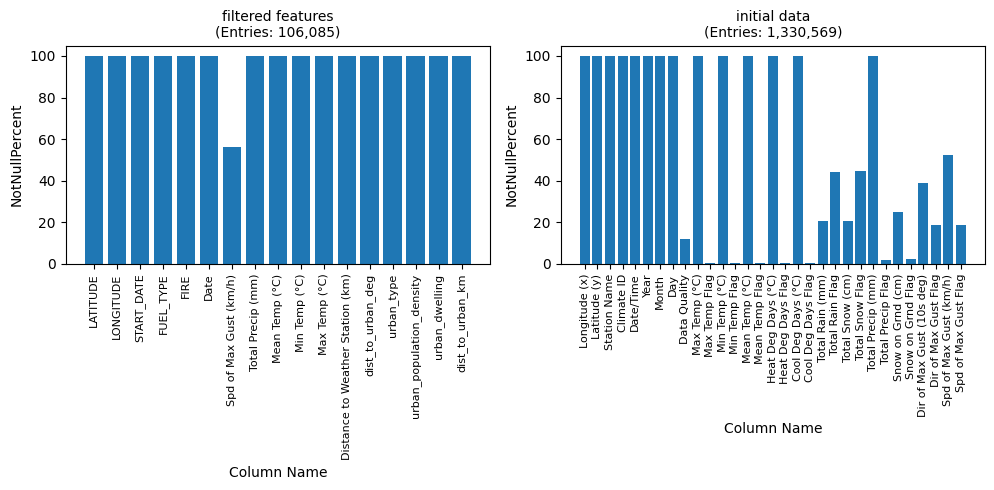

strict feature rows:  106085 total feature rows: 203177
strict feature rows has fire:  9599 total feature has fire rows: 18931
strict feature rows no fire:  96486 total feature no fire rows: 184246


In [10]:
# veg_mixed_fire_df = pd.read_csv("/mnt/d/446Project/WeatherTransformer/data_processing/Population_Infused.csv", encoding='utf-8', low_memory=False)

# run quick quality report from above function:
colunm_quality_df = column_empty_report(population_infused)
plot_two_dataframes([("filtered features", population_infused), ("initial data", weather_df_strict)])
# print(len(veg_mixed_fire_df[veg_mixed_fire_df["FIRE"]]))
# print(len(veg_mixed_fire_df[~veg_mixed_fire_df["FIRE"]]))
# print(len(feature_inital[~feature_inital["FIRE"]]))

### Strict ALL NOT NULL ENFORCE on Max Tmp, Percipitation, Spd of Max Gusting
print("strict feature rows: ", len(population_infused), "total feature rows:",  len(veg_mixed_fire_df))
print("strict feature rows has fire: ", len(population_infused[population_infused["FIRE"]]), "total feature has fire rows:",  len(veg_mixed_fire_df[veg_mixed_fire_df["FIRE"]]))
print("strict feature rows no fire: ", len(population_infused[~population_infused["FIRE"]]), "total feature no fire rows:",  len(veg_mixed_fire_df[~veg_mixed_fire_df["FIRE"]]))

In [11]:
from geopy.geocoders import Nominatim
import pandas as pd
import time

# List of cities and their associated data
cities_info = [
    ("Airdrie", 25449, 37.6),
    ("Brooks", 18527, 29.3),
    ("Calgary", 25268, 38.2),
    ("Edmonton", 32811, 36.9),
    ("Edson", 45124, 46.8),
    ("Fort McMurray", 22290, 33.0),
    ("Grand Prairie", 17094, 26.7),
    ("High Level", 12029, 27.2),
    ("Hinton", 24563, 40.2),
    ("Lethbridge", 15942, 26.1),
    ("Lloydminster", 27830, 30.2),
    ("Medicine Hat", 18059, 29.2),
    ("Red Deer", 29150, 36.6),
    ("Slave Lake", 27752, 32.1),
    ("St. Albert", 32538, 36.1)
]

geolocator = Nominatim(user_agent="alberta_city_locator")

results = []
for city, value1, value2 in cities_info:
    try:
        location = geolocator.geocode(f"{city}, Alberta, Canada", timeout=10)
        if location:
            results.append({
                "City": city,
                "Latitude": location.latitude,
                "Longitude": location.longitude,
                "Value1": value1,
                "Value2": value2
            })
        else:
            print(f"Location not found for: {city}")
            results.append({
                "City": city,
                "Latitude": None,
                "Longitude": None,
                "Value1": value1,
                "Value2": value2
            })
        time.sleep(1)  # be polite to the API
    except Exception as e:
        print(f"Error locating {city}: {e}")

# Convert to DataFrame and save
df = pd.DataFrame(results)
df.to_csv("alberta_city_locations.csv", index=False)

print(df)


             City   Latitude   Longitude  Value1  Value2
0         Airdrie  51.285970 -114.010620   25449    37.6
1          Brooks  50.571027 -111.893005   18527    29.3
2         Calgary  51.045606 -114.057541   25268    38.2
3        Edmonton  53.546205 -113.491241   32811    36.9
4           Edson  53.585866 -116.442847   45124    46.8
5   Fort McMurray  56.729200 -111.388522   22290    33.0
6   Grand Prairie  55.171080 -118.794987   17094    26.7
7      High Level  58.511536 -117.143876   12029    27.2
8          Hinton  53.399051 -117.588677   24563    40.2
9      Lethbridge  49.694578 -112.833103   15942    26.1
10   Lloydminster  53.279995 -110.008850   27830    30.2
11   Medicine Hat  50.043030 -110.679016   18059    29.2
12       Red Deer  52.269063 -113.814146   29150    36.6
13     Slave Lake  55.281074 -114.771788   27752    32.1
14     St. Albert  53.633239 -113.628845   32538    36.1


In [21]:
# !pip install requests beautifulsoup4
import requests
from bs4 import BeautifulSoup
import os

# Define the base URL
base_url = "https://dd.weather.gc.ca/20250316/WXO-DD/lightning/"

# Create a directory to save the downloaded files
os.makedirs("lightning_data", exist_ok=True)

# Fetch the content of the directory
response = requests.get(base_url)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find all links ending with '.tif'
    for link in soup.find_all('a', href=True):
        if link['href'].endswith('.tif'):
            file_url = base_url + link['href']
            file_name = os.path.join("lightning_data", link['href'])
            # Download the file
            with requests.get(file_url, stream=True) as file_response:
                if file_response.status_code == 200:
                    with open(file_name, 'wb') as f:
                        for chunk in file_response.iter_content(chunk_size=8192):
                            f.write(chunk)
                    print(f"Downloaded: {file_name}")
                else:
                    print(f"Failed to download: {file_url}")
else:
    print(f"Failed to access {base_url}")


Downloaded: lightning_data/20250315T2350Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0000Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0010Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0020Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0030Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0040Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0050Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0100Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0110Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0120Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0130Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0140Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0150Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0200Z_MSC_Lightning_2.5km.tif
Downloaded: lightning_data/20250316T0210Z_MSC_Lightning_2.5km.tif
Downloaded

In [19]:
import rasterio
import pandas as pd
import numpy as np

# Load the TIFF file
tif_path = "/mnt/d/446Project/WeatherTransformer/data_processing/20250316T2120Z_MSC_Lightning_2.5km.tif"
with rasterio.open(tif_path) as src:
    band = src.read(1)  # Read the first band
    transform = src.transform

# Mask out no-data values (commonly zero or a specific fill value)
masked_band = np.ma.masked_equal(band, 0)

# Generate coordinates for each cell
rows, cols = np.where(masked_band.mask == False)
values = masked_band[rows, cols]

# Convert row/col indices to geographic coordinates
longitudes, latitudes = rasterio.transform.xy(transform, rows, cols)

# Create DataFrame
data = pd.DataFrame({
    "Latitude": latitudes,
    "Longitude": longitudes,
    "Lightning_Count": values
})

# Save to CSV
csv_output_path = "lightning_occurrence_extracted.csv"
print("saved to lightning_occurrence_extracted.csv")
data.to_csv(csv_output_path, index=False)


print(data["Lightning_Count"].max())


saved to lightning_occurrence_extracted.csv
0.58212024
